In [2]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt


vou fazer a analise de uma imagem pra ver como é o histograma, ELA e outras caracteristicas estatisticas


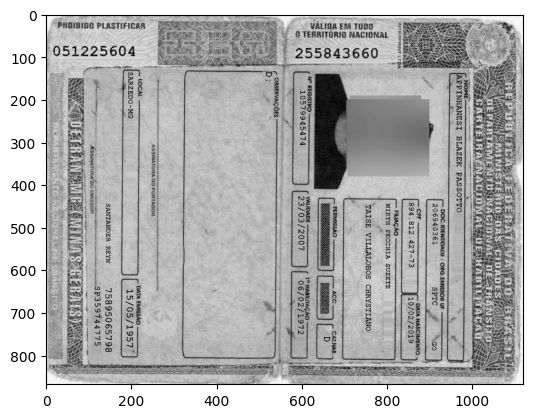

In [3]:
# importando UMA IMAGEM DO CONJUNTO DE DADOS
IMAGE_PATH = 'CNH_Aberta/00000000_in.jpg'
image = cv2.imread(IMAGE_PATH)
image_pb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255.0

plt.imshow(image_pb, cmap='gray')
plt.show()

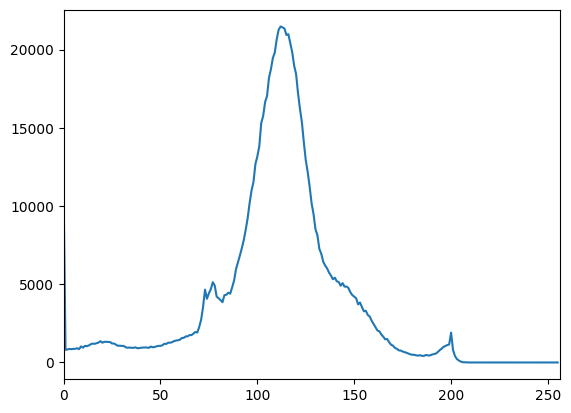

In [4]:
#plotando o histograma da imagem
hist = cv2.calcHist([image], [0], None, [256], [0, 256])
plt.plot(hist)
plt.xlim([0, 256])
plt.show()

### ELA
Vou salvar a imagem com uma compressão de 90% e comparar (diff) com a original, as partes como a diferença grande, provavelmente são as que foram comprimidas em separado do resto da imagem

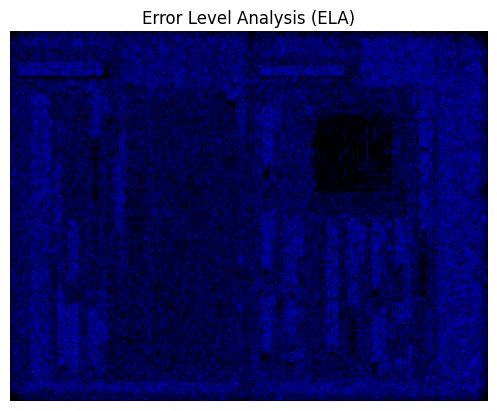

In [5]:
# salvando a imagem com compressão de 90%
cv2.imwrite('compressed.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
# lendo a imagem comprimida
compressed_image = cv2.imread('compressed.jpg')
# convertendo para float32 para evitar overflow
image_float = image.astype(np.float32)
compressed_float = compressed_image.astype(np.float32)
# calculando a diferença absoluta entre a imagem original e a comprimida
diff = cv2.absdiff(image_float, compressed_float)
# amplificando a diferença para visualização
diff_amplified = cv2.multiply(diff, np.array([50.0]))#aqui mult bem alto pra ficar mais visivelgit 
# convertendo de volta para uint8
diff_uint8 = cv2.convertScaleAbs(diff_amplified)
# exibindo a imagem de diferença
plt.imshow(cv2.cvtColor(diff_uint8, cv2.COLOR_BGR2RGB))
plt.title('Error Level Analysis (ELA)')
plt.axis('off')
plt.show()

A imagem analisada tem 2 grandes alterações: os campos tivem as palavras alteradas e as bordas do documento possivelmente pertencem a outra imagem

### AREAS COLADAS, CLONADAS E/OU MOVIDAS

In [6]:
# usando SIFT para detectar pontos chave e descrever características locais
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(image.astype(np.uint8), None)
# criando um matcher BF (Brute Force)
bf = cv2.BFMatcher.create(cv2.NORM_L2, crossCheck=False)

# encontrando os melhores matches
matches = bf.knnMatch(des, des, k=2)

In [19]:
DISTANCIA_MINIMA = 1100.0 # distância mínima para considerar um bom match

#filtrando os bons matches usando o critério de razão de Lowe (quanto menor melhor)
good_matches = []
for m, n in matches:
    if m.queryIdx == n.trainIdx:
        continue # ignorar matches do mesmo ponto
    pt1 = np.array(kp[m.queryIdx].pt)
    pt2 = np.array(kp[n.trainIdx].pt)

    distancia = np.linalg.norm(pt1 - pt2)

    if distancia > DISTANCIA_MINIMA:
        good_matches.append((pt1, pt2))

print(f'Número de bons matches encontrados: {len(good_matches)}')

Número de bons matches encontrados: 271


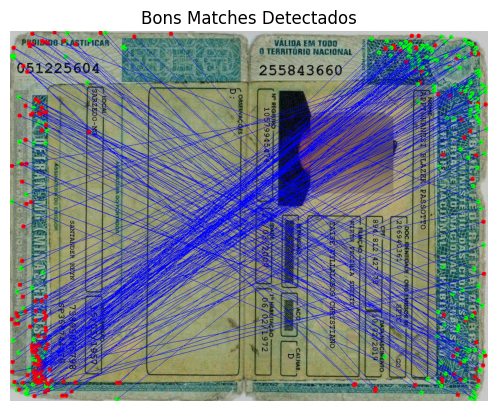

In [20]:
# visualizando os bons matches
match_image = image.copy()
for pt1, pt2 in good_matches:
    pt1 = tuple(map(int, pt1))
    pt2 = tuple(map(int, pt2))
    cv2.circle(match_image, pt1, 5, (0, 255, 0), -1)
    cv2.circle(match_image, pt2, 5, (0, 0, 255), -1)
    cv2.line(match_image, pt1, pt2, (255, 0, 0), 1)

sublot = plt.subplot(1, 1, 1)
sublot.imshow(cv2.cvtColor(match_image, cv2.COLOR_BGR2RGB))
sublot.set_title('Bons Matches Detectados')
sublot.axis('off')
plt.show()


### ISSO NAO AJUDOU MUITO!